# Correlation matrices visualization of CIFAR-100 models

In [ ]:
!export PYTHONPATH="/home/fabien/Documents/project/2d/mdistiller:$PYTHONPATH"

In [89]:
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn
from collections import OrderedDict
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
from sklearn.manifold import TSNE

from scipy.stats import ks_2samp
from scipy.stats import wasserstein_distance
from sklearn.decomposition import PCA
import seaborn as sns

from mdistiller.models import cifar_model_dict
from mdistiller.dataset import get_dataset
from mdistiller.engine.utils import load_checkpoint
from mdistiller.engine.cfg import CFG as cfg

In [82]:
def load_model(tea, stu, mpath):
    cfg.defrost()
    cfg.DISTILLER.STUDENT = stu
    cfg.DISTILLER.TEACHER = tea
    cfg.DATASET.TYPE = 'cifar100'
    cfg.freeze()
    train_loader, val_loader, num_data, num_classes = get_dataset(cfg)
    model = cifar_model_dict[cfg.DISTILLER.STUDENT][0](num_classes=num_classes)
    fully_state = load_checkpoint(mpath)["model"]
    student_weights = OrderedDict()
    teacher_weights = OrderedDict()

    for key, value in fully_state.items():
        # 检查权重键是否包含 "student"
        if 'student' in key:
            key = key.replace("module.student.", "")
            student_weights[key] = value
        if 'teacher' in key:
            key = key.replace("module.teacher.", "")
            teacher_weights[key] = value
    # model.load_state_dict(load_checkpoint(mpath)["model"])
    # tea_model = cifar_model_dict[cfg.DISTILLER.TEACHER][0](num_classes=num_classes)
    # tea_model.load_state_dict(load_checkpoint(cifar_model_dict[cfg.DISTILLER.TEACHER][1])["model"])
    model.load_state_dict(student_weights)
    tea_model = cifar_model_dict[cfg.DISTILLER.TEACHER][0](num_classes=num_classes)
    tea_model.load_state_dict(teacher_weights)
    print("load {} successfully!".format(mpath))
    return model, tea_model, val_loader

In [83]:
# visualize the difference between the teacher's output logits and the student's
def get_output_metric(model, val_loader, num_classes=100):
    model.eval()
    feat = []
    label = []
    with torch.no_grad():
        for i, (data, labels) in tqdm(enumerate(val_loader)):
            outputs, features = model(data)
            feat.append(features['pooled_feat'].data.cpu().numpy())
            label.append(labels.data.cpu().numpy())
            # all_feat.append(preds["feats"][-2].data.cpu().numpy())
            # all_labels.append(labels.data.cpu().numpy())
    all_features = np.concatenate(feat, 0)
    all_labels = np.concatenate(label, 0)
    return all_features, all_labels

def get_feat_output(tea, stu, mpath):
    cfg.defrost()
    cfg.DISTILLER.STUDENT = stu
    cfg.DISTILLER.TEACHER = tea
    cfg.DATASET.TYPE = 'cifar100'
    cfg.freeze()
    train_loader, val_loader, num_data, num_classes = get_dataset(cfg)
    model = cifar_model_dict[cfg.DISTILLER.STUDENT][0](num_classes=num_classes)
    # model.load_state_dict(load_checkpoint(mpath)["model"])
    tea_model = cifar_model_dict[cfg.DISTILLER.TEACHER][0](num_classes=num_classes)
    # tea_model.load_state_dict(load_checkpoint(cifar_model_dict[cfg.DISTILLER.TEACHER][1])["model"])
    model, tea_model, val_loader = load_model(tea, stu, mpath)
    print("load model successfully!")
    s_feat, s_label = get_output_metric(model, val_loader)
    t_feat, t_label = get_output_metric(tea_model, val_loader)
    return s_feat, s_label, t_feat, t_label, num_classes

def plot_features(features, labels, num_classes):
    colors = ['C' + str(i) for i in range(num_classes)]
    plt.figure(figsize=(6, 6))
    for l in range(num_classes):
        plt.scatter(
            features[labels == l, 0],
            features[labels == l, 1],
            c=colors[l], s=1, alpha=0.4)
    plt.xticks([])
    plt.yticks([])
    plt.show()

def get_tsne(tea, stu, mpath):
    s_feat, s_label, t_feat, t_label, num_classes = get_feat_output(tea, stu, mpath)
    tsne = TSNE()
    s_all_features = tsne.fit_transform(s_feat)
    plot_features(s_all_features, s_label, num_classes)
    t_all_features = tsne.fit_transform(t_feat)
    plot_features(t_all_features, t_label, num_classes)





In [ ]:
mpath = "/home/fabien/Documents/project/2d/mdistiller/tools/output/final/324_84/fitnet_324_84/best"
get_tsne("resnet32x4", "resnet8x4", mpath)

In [ ]:
mpath = "/home/fabien/Documents/project/2d/mdistiller/tools/output/final/DFKD/324_84/own/v1-1-1LOG.WANDB:True/best"
get_tsne("resnet32x4", "resnet8x4", mpath)


In [87]:
ori_mpath = "/home/fabien/Documents/project/2d/mdistiller/tools/output/final/324_84/fitnet_324_84/best"
aug_mpath = "/home/fabien/Documents/project/2d/mdistiller/tools/output/final/DFKD/324_84/own/fitnetDFKD_73.07/epoch_240"
s_feat_ori, s_label_ori, t_feat, t_label, _ = get_feat_output("resnet32x4", "resnet8x4", ori_mpath)
s_feat_aug, s_label_aug, t_feat, t_label, _ = get_feat_output("resnet32x4", "resnet8x4", aug_mpath)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
load /home/fabien/Documents/project/2d/mdistiller/tools/output/final/324_84/fitnet_324_84/best successfully!
load model successfully!


157it [00:11, 13.34it/s]
157it [01:13,  2.15it/s]


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
load /home/fabien/Documents/project/2d/mdistiller/tools/output/final/DFKD/324_84/own/fitnetDFKD_73.07/epoch_240 successfully!
load model successfully!


157it [00:12, 12.84it/s]
157it [01:20,  1.94it/s]


In [88]:
pca = PCA(n_components=50)
s_all_features_ori = pca.fit_transform(s_feat_ori)
s_all_features_aug = pca.fit_transform(s_feat_aug)

# KS测试
ks_stats = np.array([ks_2samp(s_all_features_ori[:, i], s_all_features_aug[:, i]) for i in range(s_all_features_ori.shape[1])])
ks_p_values = ks_stats[:, 1]

# Wasserstein距离
wasserstein_distances = np.array([wasserstein_distance(s_all_features_ori[:, i], s_all_features_aug[:, i]) for i in range(s_all_features_aug.shape[1])])

# 输出统计结果
print(f'Mean KS p-value: {np.mean(ks_p_values)}')
print(f'Mean Wasserstein distance: {np.mean(wasserstein_distances)}')

# 根据统计测试结果判断
if np.mean(ks_p_values) > 0.05 and np.mean(wasserstein_distances) < 0.1:  # threshold根据实际情况调整
    print("特征图可能来自相同分布。")
else:
    print("特征图可能来自不同分布。")

Mean KS p-value: 0.2666952602322319
Mean Wasserstein distance: 0.05089985099547158
特征图可能来自不同分布。


In [105]:
s_feat_ori.shape

(10000, 256)

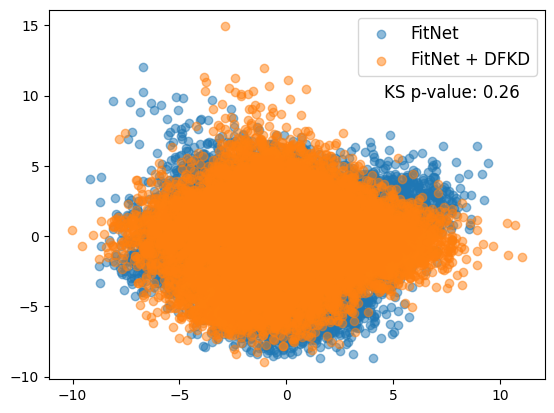

In [116]:
pca = PCA(n_components=2)
feature1_pca = pca.fit_transform(s_feat_ori)
feature2_pca = pca.fit_transform(s_feat_aug)
legend_font = {"family" : "Times New Roman"}

plt.scatter(feature1_pca[:, 0], feature1_pca[:, 1], alpha=0.5, label='FitNet')
plt.scatter(feature2_pca[:, 0], feature2_pca[:, 1], alpha=0.5, label='FitNet + DFKD')
plt.legend(fontsize='large')
# plt.title('Comparison of feature distribution visualization')
plt.text(x=0.95, y=0.8, s="KS p-value: 0.26", horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, fontsize='large')
plt.savefig('/home/fabien/Documents/project/2d/mdistiller/tools/visualizations/dfkd/Scatter_Plot_Comparison.pdf', format='pdf')
# plt.xlabel('PCA1')
# plt.ylabel('PCA2')
plt.show()

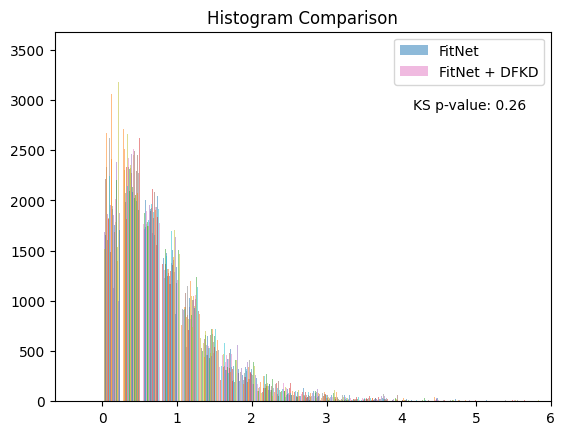

In [104]:
plt.hist(s_feat_ori, bins=50, alpha=0.5, label='FitNet')
plt.hist(s_feat_aug, bins=50, alpha=0.5, label='FitNet + DFKD')
plt.legend()
plt.title('Histogram Comparison')

plt.xlim(left=None, right=6)
plt.text(x=0.95, y=0.82, s="KS p-value: 0.26", horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)
plt.savefig('/home/fabien/Documents/project/2d/mdistiller/tools/visualizations/dfkd/histogram_comparison.pdf', format='pdf')
plt.show()

sns.kdeplot(feature1, label='Feature Set 1')
sns.kdeplot(feature2, label='Feature Set 2')

# # 绘制密度图
# sns.kdeplot(s_feat_ori, fill=True, label='Feature 1')
# sns.kdeplot(s_feat_aug, fill=True, label='Feature 2')
# plt.legend()
# plt.title('Density Plot Comparison')
# plt.show()

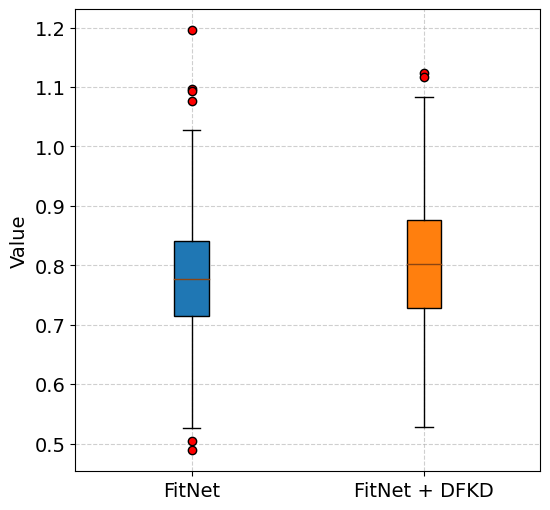

In [128]:
feature1_means = np.mean(s_feat_ori, axis=0)
feature2_means = np.mean(s_feat_aug, axis=0)
data = [feature1_means, feature2_means]
labels = ['FitNet', 'FitNet + DFKD']

# 绘制箱型图
plt.figure(figsize=(6, 6))
bplot = plt.boxplot(data, labels=labels, patch_artist=True)  # 添加 patch_artist=True 来填充箱体颜色

# 设置颜色
colors = ['#1f77b4', "#ff7f0e"]  # 你可以根据需要调整颜色代码
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

# 设置中位数线的颜色为黑色
for median in bplot['medians']:
    median.set_color('#8B4513')  # 将中位数线设置为黑色

for flier in bplot['fliers']:
    flier.set_markerfacecolor('red')  # 设置异常点为红色
    flier.set_marker('o')

# 设置坐标轴标签和标题的字体大小
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Value', fontsize=14)

# 添加网格线
plt.grid(True, linestyle='--', alpha=0.6)

# 保存图片
plt.savefig('/home/fabien/Documents/project/2d/mdistiller/tools/visualizations/dfkd/box_plot.pdf', format='pdf')

# 显示图表
plt.show()


In [94]:
s_feat_ori.shape

(10000, 256)